# Collision strengths and transition probabilities for Co III forbidden lines

#### -- by [Jiaxuan Li](https://astrojacobli.github.io)

In [31]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column, vstack

plt.rc('font', size=20)
plt.rc('text', usetex=True)

In [6]:
# Import A_ij table
Atable = Table.read('Atable_Storey2016.txt', format='ascii.fixed_width')
# Import energy level table
energy_level = Table.read('energy_levels_lowest15.txt', format='ascii')
energy_level.add_column(Column(data=energy_level['Jn'] / energy_level['Jd'], name='J', dtype='float64'))

# Import Y_ij table
Ytable = Table.read('Tave_collision_strength.txt', format='ascii')
temp_set = np.arange(2.0, 4.6, 0.2)
for i in range(len(temp_set)):
    Ytable['col' + str(i + 3)].name = str(round(temp_set[i], 1))
Ytable['col1'].name = 'i'
Ytable['col2'].name = 'j'

# Step by step:

In [3]:
n_e = 1e7
log_T = 4.0

## The equation should be $(j>i>k)$:
\begin{equation}
\frac{\mathrm{d}n_i}{\mathrm{d}t} = A_{ij}n_{j} - A_{ki} n_{i} + P_{ij} n_e n_j - P_{ki} n_e n_i + Q_{ik} n_e n_k - Q_{ji} n_e n_i = 0,
\end{equation}
in which $$A_{ij} = A_{j\to i},$$ $$P_{ij} = q(j\to i ),$$ $$Q_{ji} = q(i \to j).$$

In this notebook, the subscription of matrix follows $A_{\rm final,\ initial}$.

# $A_{ij} = A_{j\to i}$

Text(0,0.5,'$i$')

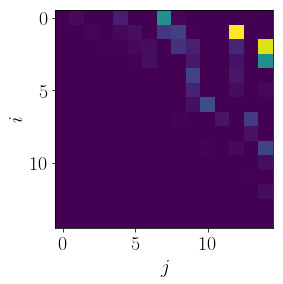

In [7]:
A_mat = np.zeros([15,15]) 
for row in Atable:
    A_mat[row['i']-1, row['j']-1] = row['Aji']

plt.imshow(A_mat)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

### $E_{ij}$

Text(0,0.5,'$i$')

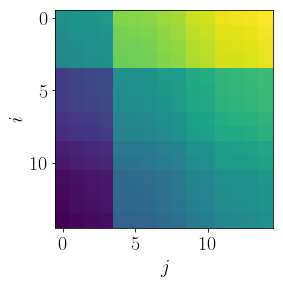

In [8]:
# E_ij: transition energy from i to j (>0 for excitation)
E_mat = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        E_mat[i, j] = energy_level[j]['Eexp'] - energy_level[i]['Eexp']
# Now convert the unit from cm^{-1} to eV
E_mat = 4.1357*1e-15 * 3 * 1e10 * E_mat
plt.imshow(E_mat)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

### $Y_{ij}$

Text(0,0.5,'$i$')

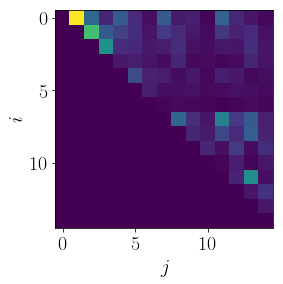

In [9]:
Y_mat = np.zeros([15,15]) 
for row in Ytable:
    Y_mat[row['i']-1, row['j']-1] = row[str(log_T)]
    
plt.imshow(Y_mat)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

### $\omega_i$

In [10]:
omega = np.zeros(15)
for row in energy_level:
    omega[row['index'] - 1] = 2*row['J'] + 1

# Now we construct the collision excitation coefficient matrix $Q$. In this matrix, $Q_{ji}$ is $q(i\to j)$, where $i<j$. It means exciting from $i$ to $j$.

In [11]:
R = 2.1716*1e-8
I_inf = 33.5 # eV
k_B = 8.6173303*1e-5 # eV/Kelvin

kT = k_B * 10**(log_T)
C = R * np.sqrt(I_inf / kT)

Q = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            Q[j, i] = C * np.exp( - E_mat[i, j] / kT  ) * Y_mat[i, j] / omega[i]

Text(0,0.5,'$i$')

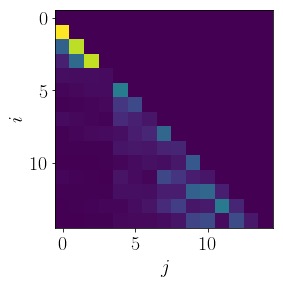

In [12]:
plt.imshow(Q)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

# Now we construct the collision de-excitation coefficient matrix $P$. In this matrix, $P_{ij}$ is $q(j\to i)$, where $i<j$. (Downward from $j$ to $i$).

In [13]:
P = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            P[i, j] = (omega[i]/ omega[j]) * np.exp( E_mat[i, j] / kT ) * Q[j, i]

Text(0,0.5,'$i$')

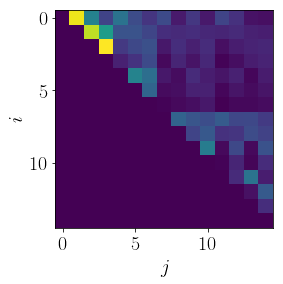

In [14]:
plt.imshow(P)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

## The equation should be $(j>i)$:
\begin{equation}
\frac{\mathrm{d}n_i}{\mathrm{d}t} = A_{ij}n_{j} - A_{ki} n_{i} + P_{ij} n_e n_j - P_{ki} n_e n_i + Q_{ik} n_e n_k - Q_{ji} n_e n_i = 0.
\end{equation}
This equation follows Einstein summing law. Change some of the $k$ into $j$, we can get:
\begin{equation}
\frac{\mathrm{d}n_i}{\mathrm{d}t} = \sum_j (A_{ij} + P_{ij} n_e + Q_{ij} n_e) n_{j} = 
\sum_j (A_{ji} + P_{ji} n_e +Q_{ji} n_e) n_i.
\end{equation}
in which $$A_{ij} = A_{j\to i},$$ $$P_{ij} = q(j\to i ),$$ $$Q_{ji} = q(i \to j).$$

## Using matrix, our equation is:
\begin{equation}
[(\mathbf{A} + n_e\mathbf{P} + n_e\mathbf{Q})\vec{n}]_i  - \{\sum_j (A_{ji} + P_{ji} n_e +Q_{ji} n_e)\} n_i = 0
\end{equation}

Let $\mathbf{C} = diag\{{\sum_j (A_{ji} + P_{ji} n_e +Q_{ji} n_e)}\}$ and $\mathbf{A}+ n_e\mathbf{P} + n_e \mathbf{Q} = \mathbf{B}$. Then
$$(\mathbf{B} - \mathbf{C})\vec{n} = 0$$
is a homogeneous linear equation system.

In [16]:
C = np.diag((n_e*Q + n_e*P + A_mat).sum(axis=0))

In [17]:
B = A_mat + n_e * P + n_e * Q

In [18]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_space = np.compress(s <= eps, vh, axis=0)
    return null_space.T

In [19]:
v = null(B - C) 
population = v / v[0]

[[1.        ]
 [0.69558263]
 [0.47295715]
 [0.29508609]
 [0.05687277]
 [0.03673786]
 [0.01784707]
 [0.04384489]
 [0.03426236]
 [0.01166833]
 [0.00555292]
 [0.02967392]
 [0.00799846]
 [0.0196831 ]
 [0.00383512]]


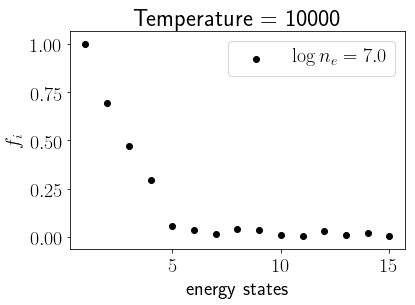

In [30]:
print(population)
plt.scatter(energy_level['index'], population, marker='o', color='k',
            label=r'$\log n_e=' + str(np.log10(n_e)) + '$')
plt.xlabel('energy states')
plt.ylabel(r'$f_i$')
plt.title('Temperature = ' + str(round(10**log_T)) )
plt.legend()

# Definition of $\rho$:
$$\rho\propto f_j A_{ij} |E_{ij}|$$

In [27]:
def cal_rho(j, i):
    return (population[j-1]  * A_mat[i-1, j-1] ) * abs(E_mat[i-1, j-1]) #+ n_e * P[i-1, j-1] * population[j-1]

In [28]:
cal_rho(8, 1) / cal_rho(13, 2)

array([2.11724911])

---

# Sum it up:

In [9]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_space = np.compress(s <= eps, vh, axis=0)
    return null_space.T
def cal_rho(j, i):
    return (population[j-1]  * A_mat[i-1, j-1] ) * abs(E_mat[i-1, j-1]) #+ n_e * P[i-1, j-1] * population[j-1]

In [21]:
n_e = 1e4
log_T = 4.0

In [22]:
A_mat = np.zeros([15,15]) 
for row in Atable:
    A_mat[row['i']-1, row['j']-1] = row['Aji']
    
# E_ij: transition energy from i to j (>0 for excitation)
E_mat = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        E_mat[i, j] = energy_level[j]['Eexp'] - energy_level[i]['Eexp']
# Now convert the unit from cm^{-1} to eV
E_mat = 4.1357*1e-15 * 3 * 1e10 * E_mat

# Y
Y_mat = np.zeros([15,15]) 
for row in Ytable:
    Y_mat[row['i']-1, row['j']-1] = row[str(log_T)]
#Y_mat = 26**2 * Y_mat
# omega
omega = np.zeros(15)
for row in energy_level:
    omega[row['index'] - 1] = 2*row['J'] + 1
    
# Q
R = 2.1716*1e-8
I_inf = 13.6 #33.5 # eV
k_B = 8.6173303*1e-5 # eV/Kelvin

kT = k_B * 10**(log_T)
C = R * np.sqrt(I_inf / kT)

Q = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            Q[j, i] = C * np.exp( - E_mat[i, j] / kT  ) * Y_mat[i, j] / omega[i]
# P
P = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            P[i, j] = (omega[i]/ omega[j]) * np.exp( E_mat[i, j] / kT ) * Q[j, i]
            
# Solve
C = np.diag((n_e*Q + n_e*P + A_mat).sum(axis=0))
B = A_mat + n_e * P + n_e * Q
v = null(B - C) 
population = v / v[0]
population

array([[1.00000000e+00],
       [2.25415812e-02],
       [1.02303119e-02],
       [6.51722604e-03],
       [1.75052825e-04],
       [9.84104158e-05],
       [3.78472113e-05],
       [2.90731634e-05],
       [9.31938632e-06],
       [4.97653533e-06],
       [1.89551669e-06],
       [1.09348628e-04],
       [1.61768707e-06],
       [5.11558067e-06],
       [2.12403343e-07]])

In [27]:
cal_rho(2, 1) / cal_rho(3, 2) 

array([4.63788912])

In [28]:
5.85 / 1.26

4.642857142857142